Basado en https://www.kaggle.com/code/jadhavpranav/timeseries-analysis-of-energy-consumption-data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
from sklearn.metrics import mean_squared_error, mean_absolute_error



In [2]:
df=pd.read_csv('power/KwhConsumptionBlower78_3.csv', parse_dates=['TxnDate'])


In [3]:
df.head()

,Unnamed: 0,TxnDate,TxnTime,Consumption
0,0,2022-02-01,14:41:48,1.016
1,1,2022-02-01,17:28:44,0.928
2,2,2022-02-01,19:51:07,0.988
3,3,2022-02-01,07:26:39,1.126
4,4,2022-02-01,05:20:47,0.886


In [4]:
df.shape

(1748, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1748 entries, 0 to 1747
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   1748 non-null   int64         
 1   TxnDate      1748 non-null   datetime64[ns]
 2   TxnTime      1748 non-null   object        
 3   Consumption  1748 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 54.8+ KB


In [6]:
df['DateTime'] = pd.to_datetime(df['TxnDate'])

In [7]:
# Elimino la columna Unnamed: 0
df.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
# Agrupo por fecha y sumo la columna Consumption
df=df.groupby('DateTime').sum('Consumption')

In [9]:
df.head()

,Consumption
DateTime,
2022-02-01,68.708
2022-02-02,67.944
2022-02-03,66.418
2022-02-04,70.006
2022-02-05,65.808


In [10]:
# Muestro la fecha minima
df.index.min()

Timestamp('2022-02-01 00:00:00')

In [11]:
# Muestro la fecha maxima
df.index.max()

Timestamp('2022-02-28 00:00:00')

In [12]:
df.shape

(28, 1)

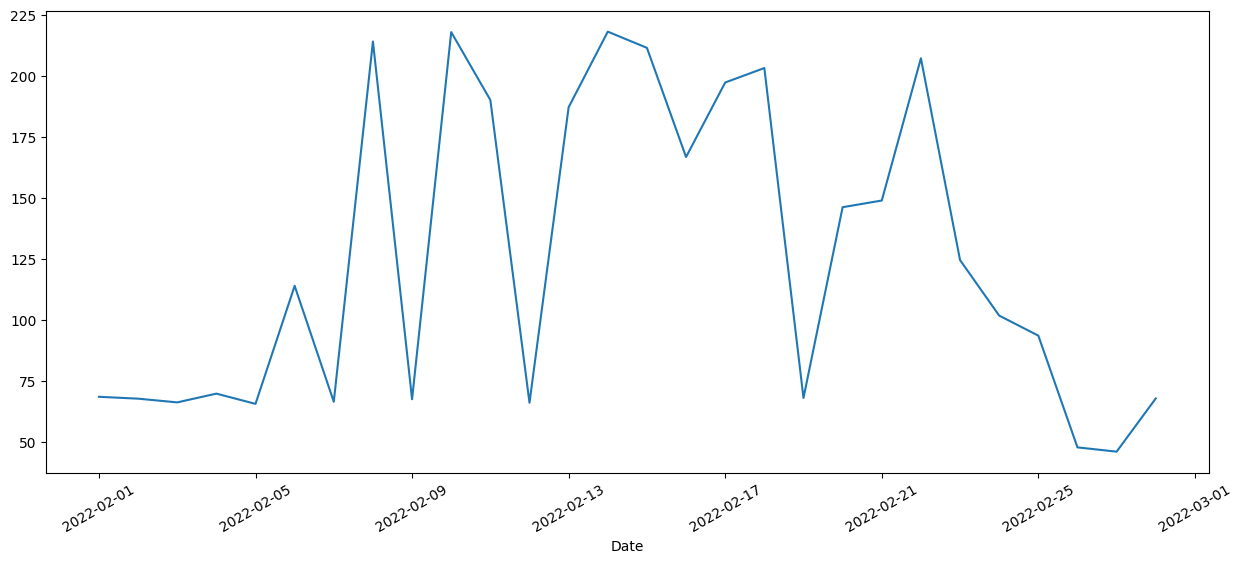

In [13]:
plt.figure(figsize=(15,6))
plt.plot(df)
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.show()

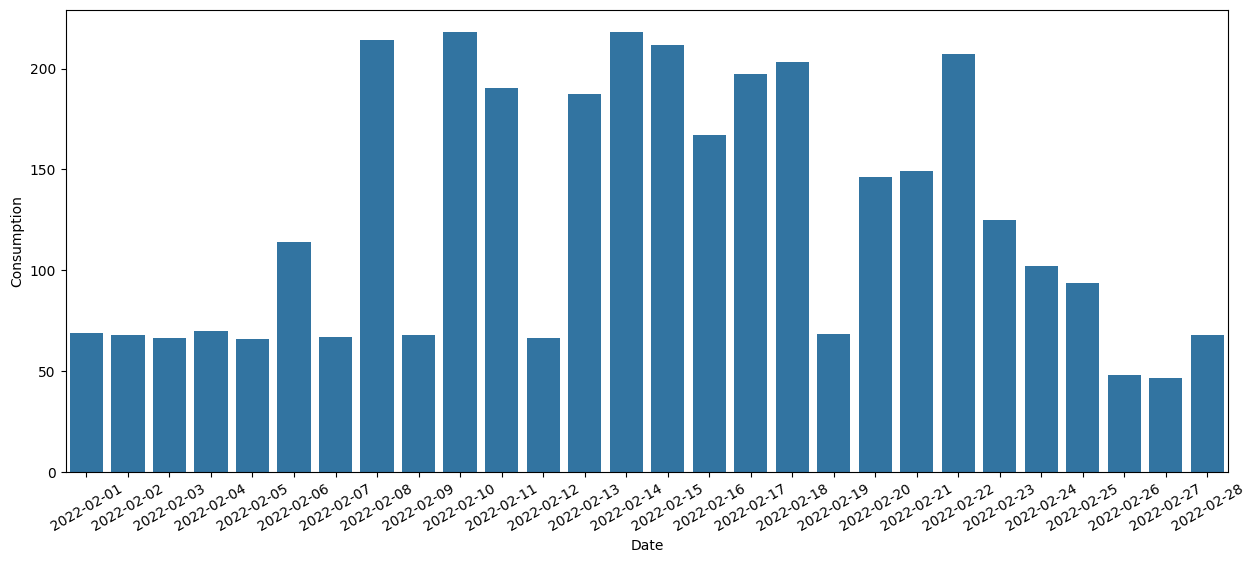

In [14]:
plt.figure(figsize=(15,6))
sns.barplot(data=df,x=df.index,y="Consumption")
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.show()

In [15]:
# Creo una ventana movial de 4 dias
# En donde se calcula el promedio de los ultimos 4 dias
rolling_mean_df=df.rolling(window=4).mean()

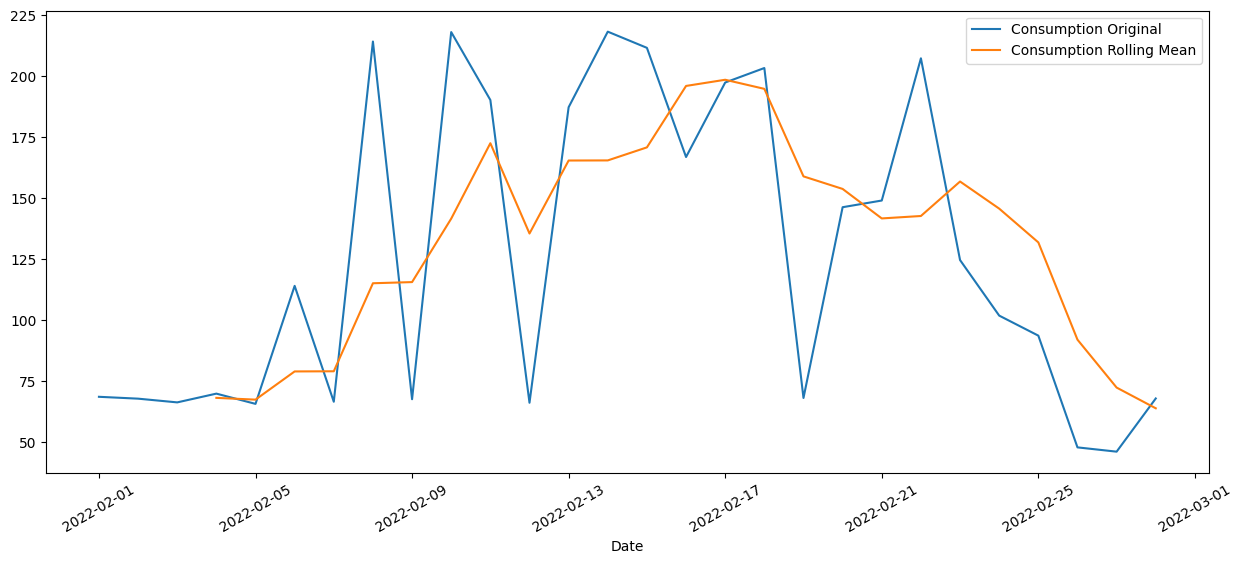

In [16]:
# Grafico la serie original y la ventana movil
plt.figure(figsize=(15,6))
plt.plot(df, label="Consumption Original")
plt.plot(rolling_mean_df, label="Consumption Rolling Mean")
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.legend()
plt.show()

In [17]:
# Convertimos la serie a una frecuencia diaria
df=df.asfreq('D') 

In [18]:
df.head()

,Consumption
DateTime,
2022-02-01,68.708
2022-02-02,67.944
2022-02-03,66.418
2022-02-04,70.006
2022-02-05,65.808


<function matplotlib.pyplot.show(close=None, block=None)>

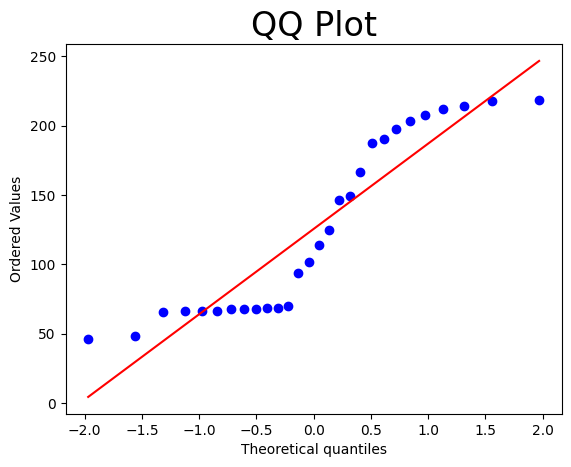

In [19]:
import scipy.stats
import pylab

# Grafico el qqplot
scipy.stats.probplot(df['Consumption'], plot=pylab)
plt.title("QQ Plot", size = 24)
plt.show

### Prueba de estacionariedad

#### Prueba de Dickey-Fuller aumentada (ADF)

In [20]:
def check_stationarity(series, name=""):
    result = sts.adfuller(series.dropna())
    print(f'Prueba ADF para {name}:')
    print(f'Estadístico: {result[0]:.4f}')
    print(f'p-valor: {result[1]:.4f}')
    print(f'Valores críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    # Interpretar resultado
    if result[1] <= 0.05:
        print(f"Conclusión: La serie {name} es estacionaria (p-valor <= 0.05)")
    else:
        print(f"Conclusión: La serie {name} no es estacionaria (p-valor > 0.05)")
    print("-" * 50)
    return result[1] <= 0.05

In [21]:
# Función para graficar series
def plot_series(original, transformed, title="Comparación de Series"):
    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    plt.plot(original)
    plt.title("Serie Original")
    plt.subplot(212)
    plt.plot(transformed, color='red')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [22]:
# Verificar la serie original
print("ANÁLISIS DE LA SERIE ORIGINAL")
is_stationary = check_stationarity(df['Consumption'], "original")

ANÁLISIS DE LA SERIE ORIGINAL
Prueba ADF para original:
Estadístico: -0.7932
p-valor: 0.8211
Valores críticos:
   1%: -3.8591
   5%: -3.0420
   10%: -2.6609
Conclusión: La serie original no es estacionaria (p-valor > 0.05)
--------------------------------------------------


Intentaremos convertirla en estacionaria


1. MÉTODO DE DIFERENCIACIÓN
Prueba ADF para primera diferencia:
Estadístico: -0.3807
p-valor: 0.9133
Valores críticos:
   1%: -3.8893
   5%: -3.0544
   10%: -2.6670
Conclusión: La serie primera diferencia no es estacionaria (p-valor > 0.05)
--------------------------------------------------


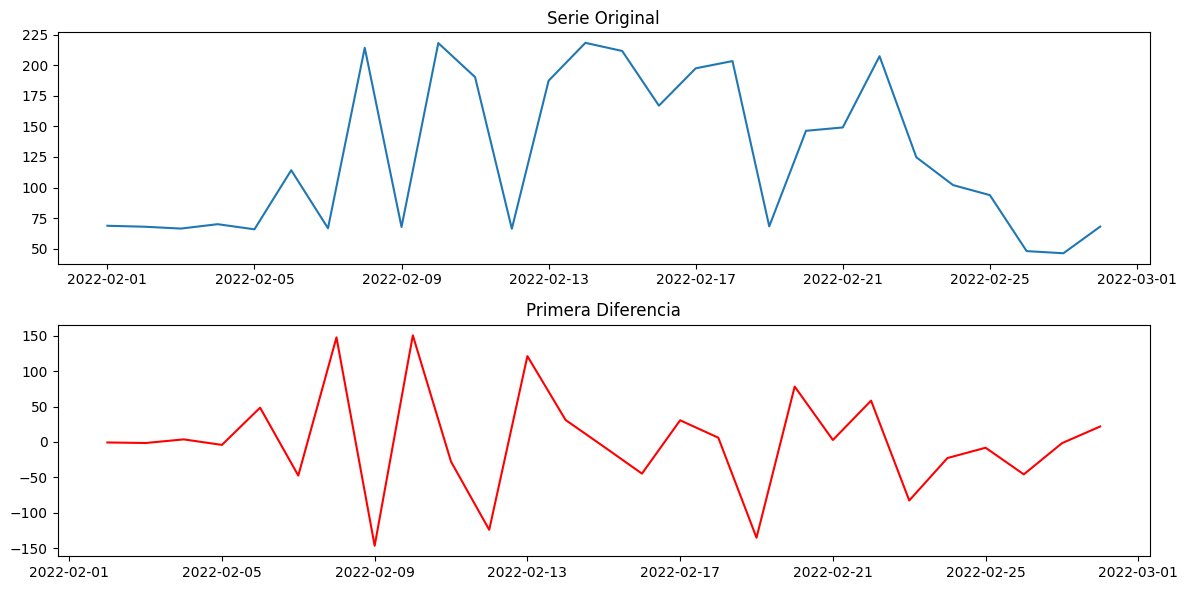

In [23]:
# 1er metodo de DIFERENCIACIÓN
print("\n1. MÉTODO DE DIFERENCIACIÓN")
# Primera diferencia
diff1 = df.diff().dropna()
is_stationary_diff1 = check_stationarity(diff1, "primera diferencia")
plot_series(df, diff1, "Primera Diferencia")

Prueba ADF para segunda diferencia:
Estadístico: -0.7934
p-valor: 0.8211
Valores críticos:
   1%: -3.9240
   5%: -3.0685
   10%: -2.6739
Conclusión: La serie segunda diferencia no es estacionaria (p-valor > 0.05)
--------------------------------------------------


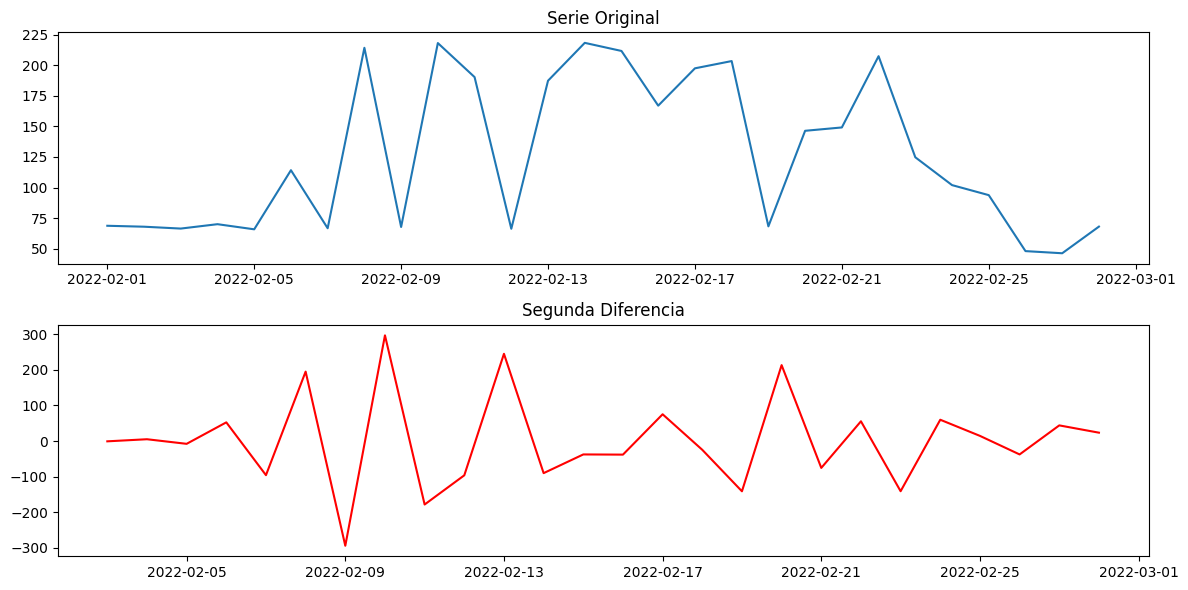

In [24]:
# Si la primera diferencia no es suficiente, intentar con la segunda
if not is_stationary_diff1:
    diff2 = diff1.diff().dropna()
    is_stationary_diff2 = check_stationarity(diff2, "segunda diferencia")
    plot_series(df, diff2, "Segunda Diferencia")


2. TRANSFORMACIONES MATEMÁTICAS
Prueba ADF para logarítmica:
Estadístico: -0.3836
p-valor: 0.9128
Valores críticos:
   1%: -3.8591
   5%: -3.0420
   10%: -2.6609
Conclusión: La serie logarítmica no es estacionaria (p-valor > 0.05)
--------------------------------------------------


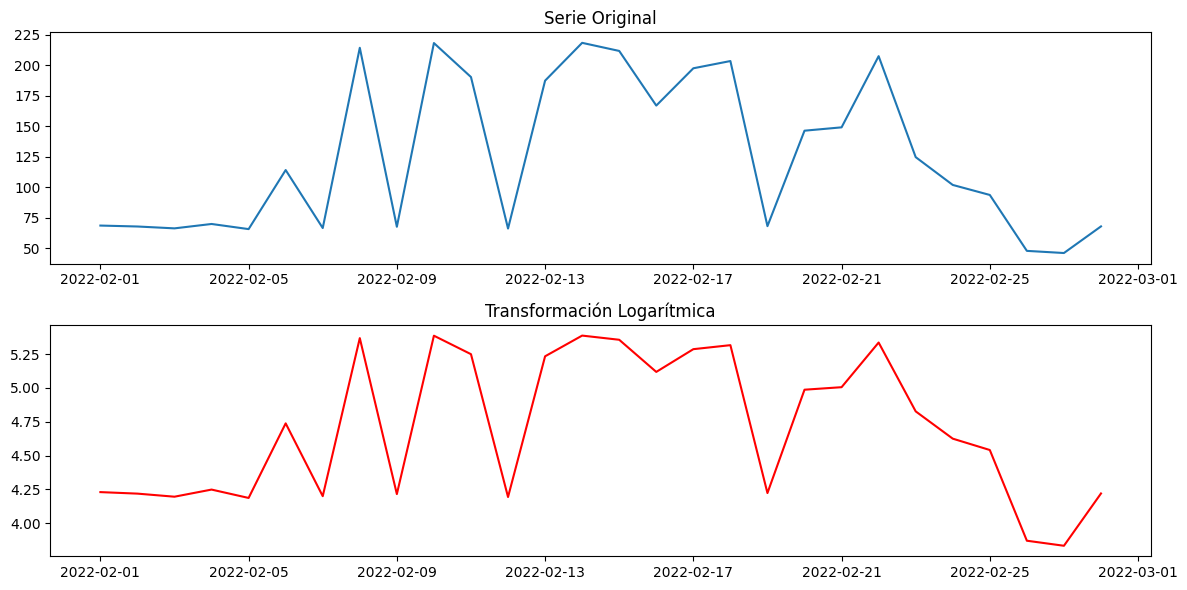

Prueba ADF para logarítmica + diferencia:
Estadístico: 0.5986
p-valor: 0.9876
Valores críticos:
   1%: -3.8893
   5%: -3.0544
   10%: -2.6670
Conclusión: La serie logarítmica + diferencia no es estacionaria (p-valor > 0.05)
--------------------------------------------------


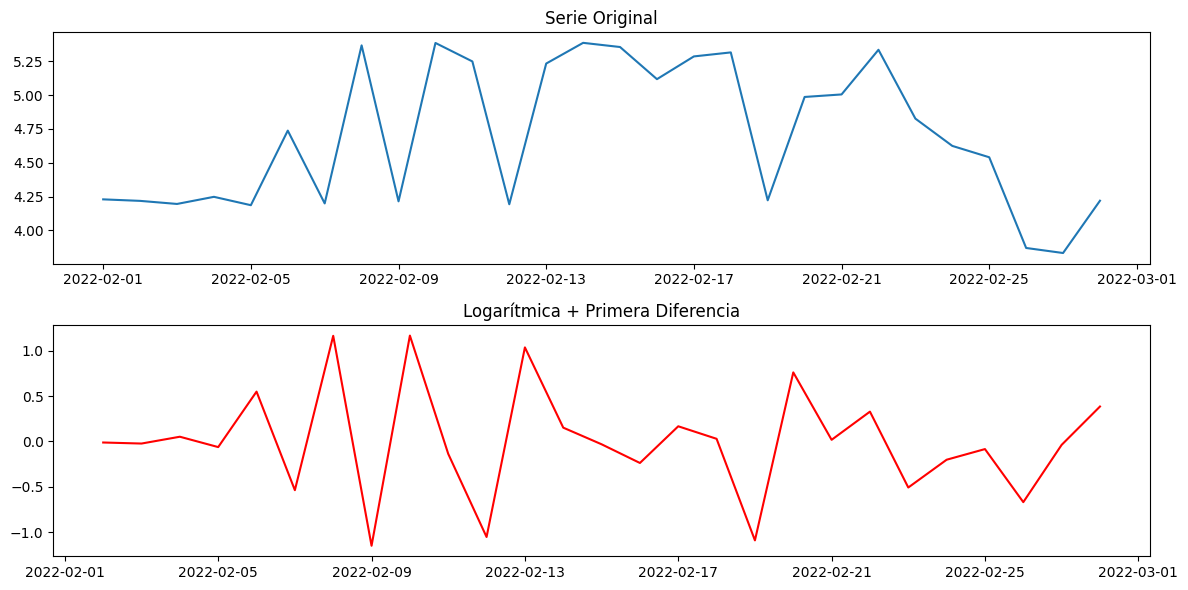

Prueba ADF para raíz cuadrada:
Estadístico: -0.6052
p-valor: 0.8698
Valores críticos:
   1%: -3.8591
   5%: -3.0420
   10%: -2.6609
Conclusión: La serie raíz cuadrada no es estacionaria (p-valor > 0.05)
--------------------------------------------------


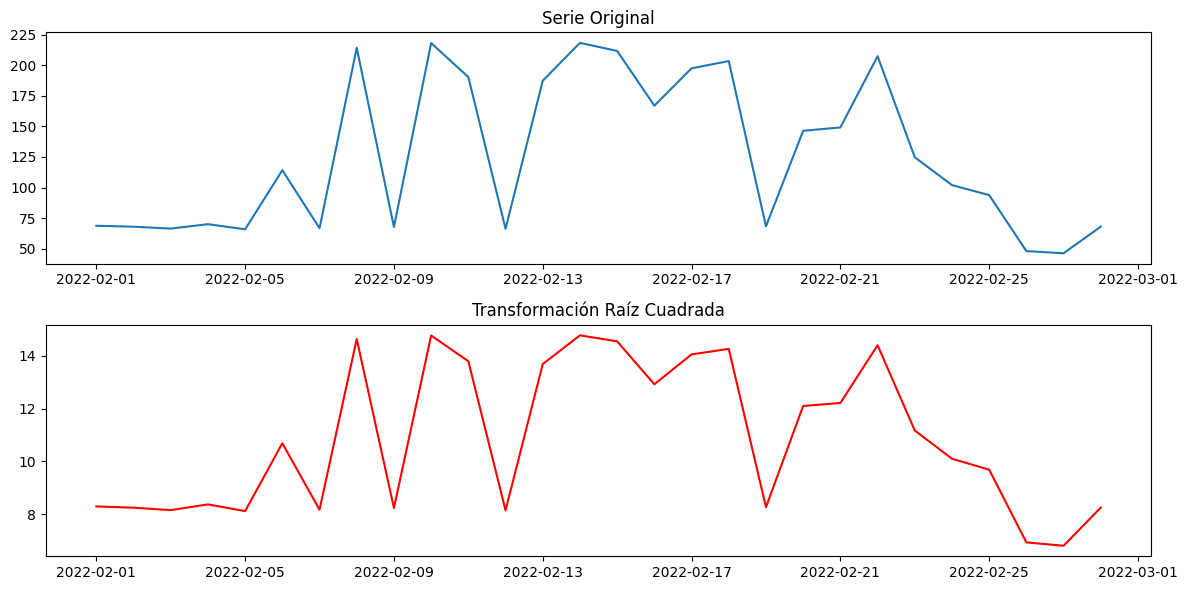

Lambda óptimo para Box-Cox: 0.0063
Prueba ADF para Box-Cox:
Estadístico: -0.3865
p-valor: 0.9123
Valores críticos:
   1%: -3.8591
   5%: -3.0420
   10%: -2.6609
Conclusión: La serie Box-Cox no es estacionaria (p-valor > 0.05)
--------------------------------------------------


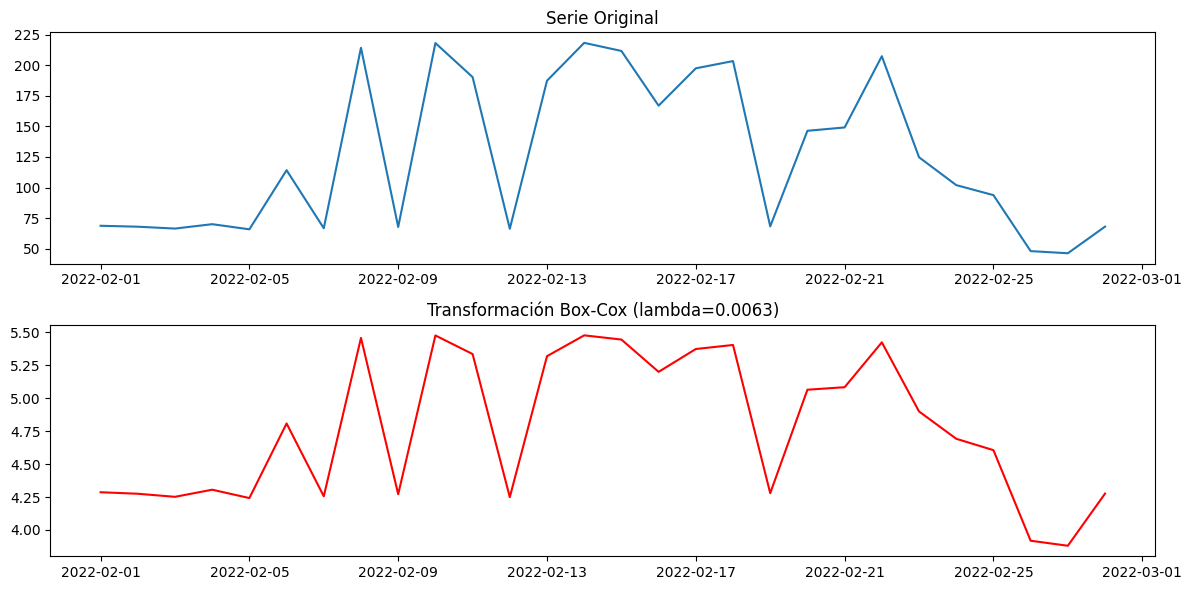

In [25]:
# 2. TRANSFORMACIONES MATEMÁTICAS
print("\n2. TRANSFORMACIONES MATEMÁTICAS")

# Transformación logarítmica (solo si todos los valores son positivos)
if (df['Consumption'] > 0).all():
    log_transform = np.log(df['Consumption'])
    is_stationary_log = check_stationarity(log_transform, "logarítmica")
    plot_series(df['Consumption'], log_transform, "Transformación Logarítmica")
    
    # Si la transformación logarítmica no es suficiente, probar log + diferenciación
    if not is_stationary_log:
        log_diff = log_transform.diff().dropna()
        is_stationary_log_diff = check_stationarity(log_diff, "logarítmica + diferencia")
        plot_series(log_transform, log_diff, "Logarítmica + Primera Diferencia")
else:
    print("La serie contiene valores no positivos, omitiendo transformación logarítmica")

# Transformación de raíz cuadrada (solo si todos los valores son positivos)
if (df['Consumption'] > 0).all():
    sqrt_transform = np.sqrt(df['Consumption'])
    is_stationary_sqrt = check_stationarity(sqrt_transform, "raíz cuadrada")
    plot_series(df['Consumption'], sqrt_transform, "Transformación Raíz Cuadrada")
else:
    print("La serie contiene valores no positivos, omitiendo transformación de raíz cuadrada")

# Transformación Box-Cox (solo para valores positivos)
if (df['Consumption'] > 0).all():
    from scipy import stats
    # Encontrar el lambda óptimo para Box-Cox
    boxcox_transform, lambda_value = stats.boxcox(df['Consumption'])
    boxcox_transform = pd.Series(boxcox_transform, index=df.index)
    print(f"Lambda óptimo para Box-Cox: {lambda_value:.4f}")
    is_stationary_boxcox = check_stationarity(boxcox_transform, "Box-Cox")
    plot_series(df['Consumption'], boxcox_transform, f"Transformación Box-Cox (lambda={lambda_value:.4f})")
else:
    print("La serie contiene valores no positivos, omitiendo transformación Box-Cox")


3. SUSTRACCIÓN DE TENDENCIA O ESTACIONALIDAD


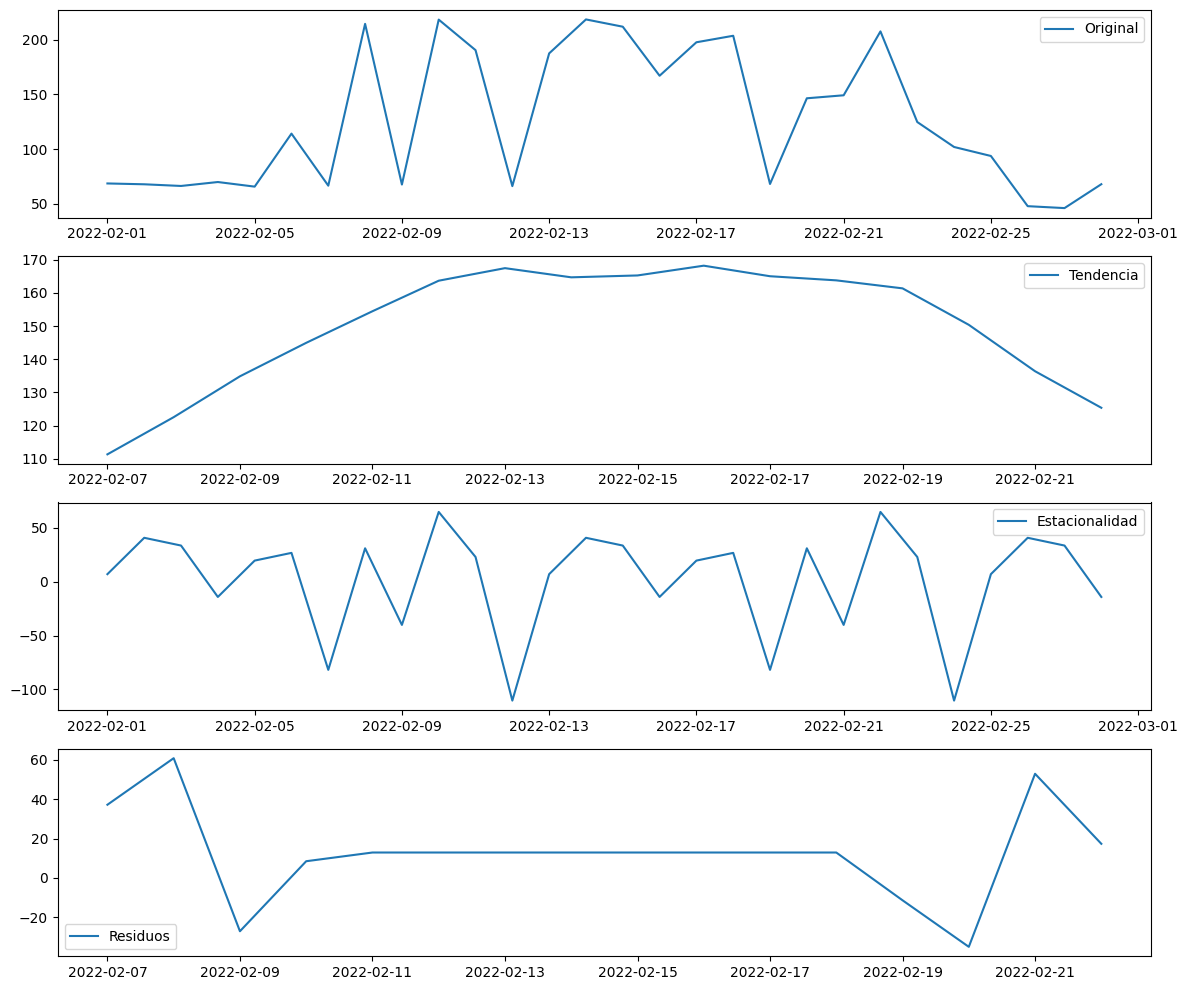

Prueba ADF para sin tendencia:
Estadístico: -3.5348
p-valor: 0.0071
Valores críticos:
   1%: -4.4731
   5%: -3.2899
   10%: -2.7724
Conclusión: La serie sin tendencia es estacionaria (p-valor <= 0.05)
--------------------------------------------------


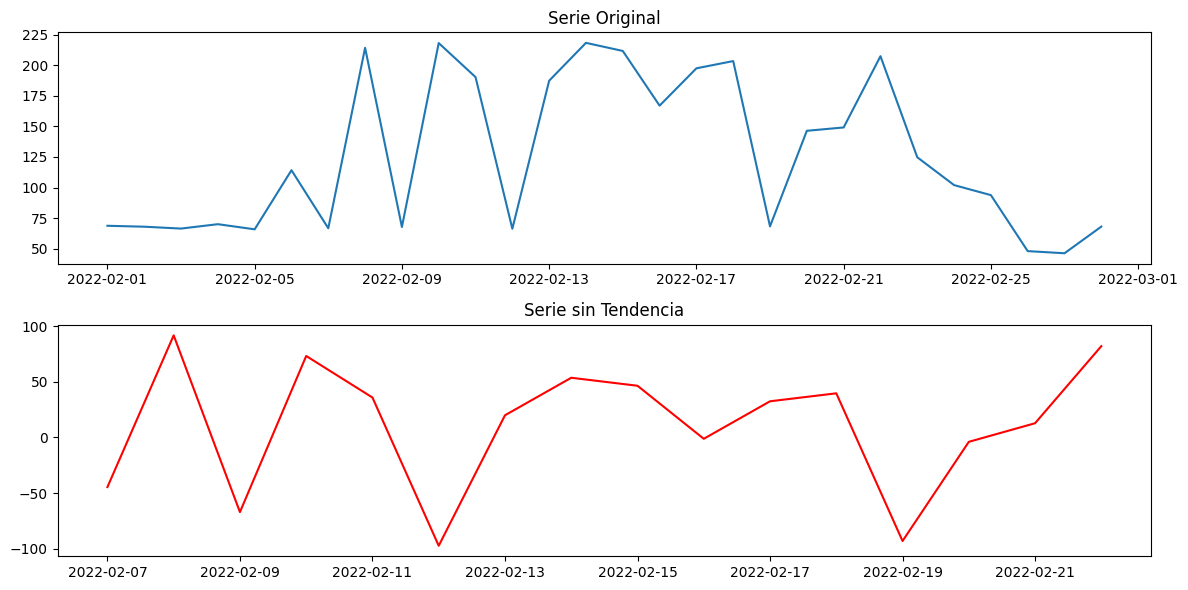

Prueba ADF para sin estacionalidad:
Estadístico: -2.4066
p-valor: 0.1399
Valores críticos:
   1%: -3.6996
   5%: -2.9764
   10%: -2.6276
Conclusión: La serie sin estacionalidad no es estacionaria (p-valor > 0.05)
--------------------------------------------------


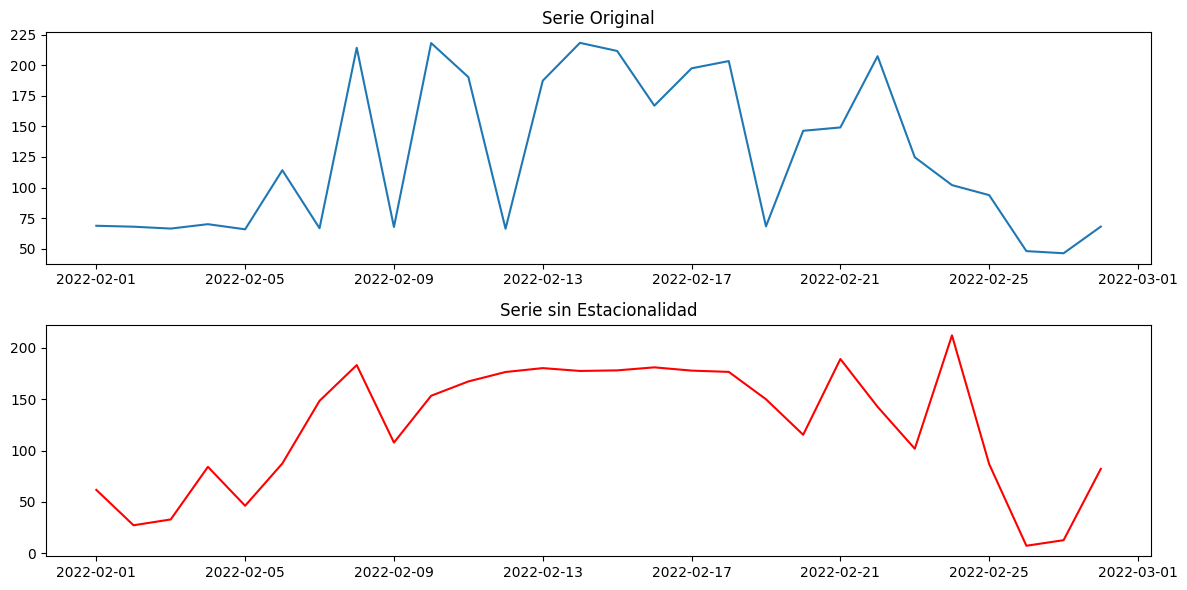

Prueba ADF para residual:
Estadístico: -2.7519
p-valor: 0.0655
Valores críticos:
   1%: -4.0689
   5%: -3.1271
   10%: -2.7017
Conclusión: La serie residual no es estacionaria (p-valor > 0.05)
--------------------------------------------------


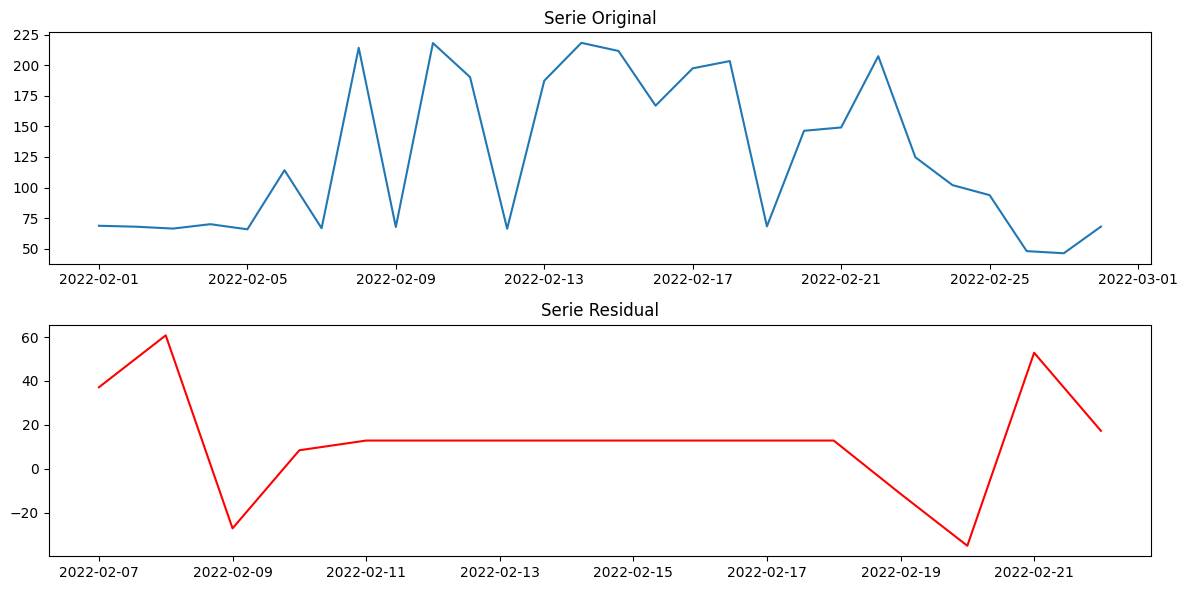

In [26]:
# 3. SUSTRACCIÓN DE TENDENCIA O ESTACIONALIDAD
print("\n3. SUSTRACCIÓN DE TENDENCIA O ESTACIONALIDAD")

# Descomposición de series temporales
try:
    # Determinar frecuencia de datos (ajustar según tu serie)
    # Para datos diarios: freq=7, para datos mensuales: freq=12, etc.
    # Si los datos no tienen una frecuencia conocida, se puede usar un valor estimado
    freq = 12  # Ajustar según tu serie
    
    decomposition = seasonal_decompose(df['Consumption'], model='additive', period=freq)
    
    # Graficar descomposición
    plt.figure(figsize=(12, 10))
    plt.subplot(411)
    plt.plot(df['Consumption'], label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Tendencia')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Estacionalidad')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuos')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # Serie sin tendencia
    detrended = df['Consumption'] - decomposition.trend
    detrended = detrended.dropna()
    is_stationary_detrended = check_stationarity(detrended, "sin tendencia")
    plot_series(df['Consumption'], detrended, "Serie sin Tendencia")
    
    # Serie sin estacionalidad
    deseasonalized = df['Consumption'] - decomposition.seasonal
    is_stationary_deseasonalized = check_stationarity(deseasonalized, "sin estacionalidad")
    plot_series(df['Consumption'], deseasonalized, "Serie sin Estacionalidad")
    
    # Serie con solo residuos (sin tendencia ni estacionalidad)
    residual = decomposition.resid
    residual = residual.dropna()
    is_stationary_residual = check_stationarity(residual, "residual")
    plot_series(df['Consumption'], residual, "Serie Residual")
    
except Exception as e:
    print(f"Error en la descomposición de la serie: {e}")
    print("Intenta ajustar la frecuencia (period) según tus datos")
    
    # Alternativa: Eliminar tendencia usando regresión lineal
    X = np.arange(len(df['Consumption']))
    y = df['Consumption'].values
    X = np.vstack([X, np.ones(len(X))]).T
    
    # Ajustar modelo de regresión lineal
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(X[:, 0].reshape(-1, 1), y)
    
    # Predecir tendencia
    trend = model.predict(X[:, 0].reshape(-1, 1))
    
    # Eliminar tendencia
    detrended_linear = df['Consumption'] - trend
    detrended_linear = pd.Series(detrended_linear, index=df.index)
    is_stationary_detrended_linear = check_stationarity(detrended_linear, "sin tendencia lineal")
    plot_series(df['Consumption'], detrended_linear, "Serie sin Tendencia Lineal")


Prueba ADF para sin tendencia lineal:
Estadístico: -3.0162
p-valor: 0.0334
Valores críticos:
   1%: -3.9644
   5%: -3.0849
   10%: -2.6818
Conclusión: La serie sin tendencia lineal es estacionaria (p-valor <= 0.05)
--------------------------------------------------


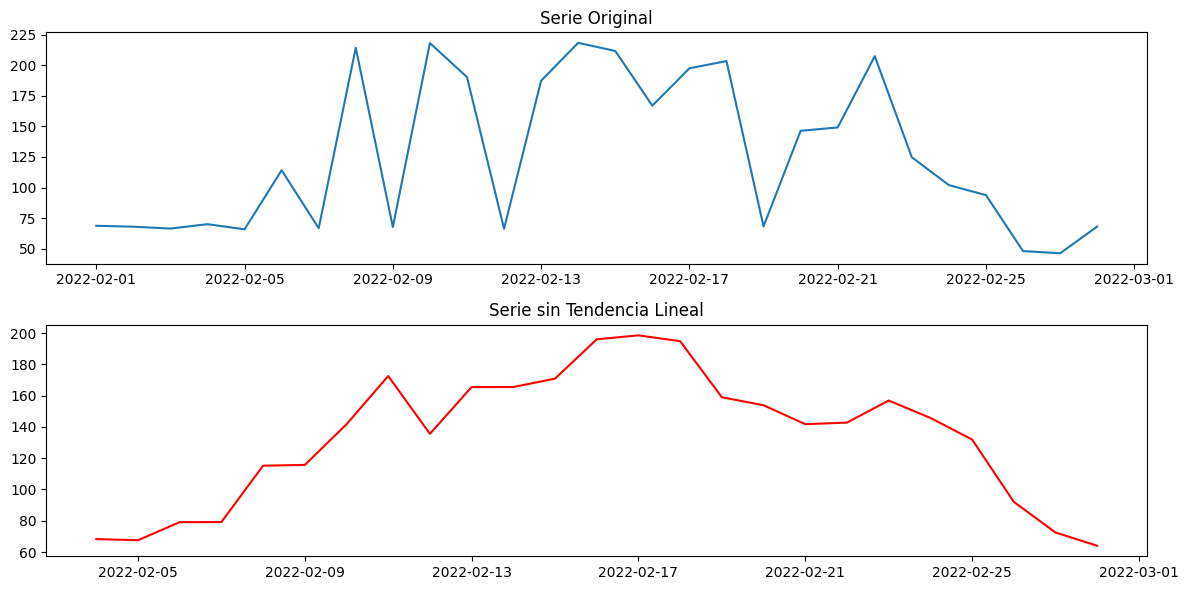

In [27]:
# Pruebo aplicando una ventana movil de 4 dias
rolling_mean_df=df.rolling(window=4).mean()
is_stationary_rolling_mean = check_stationarity(rolling_mean_df, "sin tendencia lineal")
plot_series(df['Consumption'], rolling_mean_df, "Serie sin Tendencia Lineal")

PACG

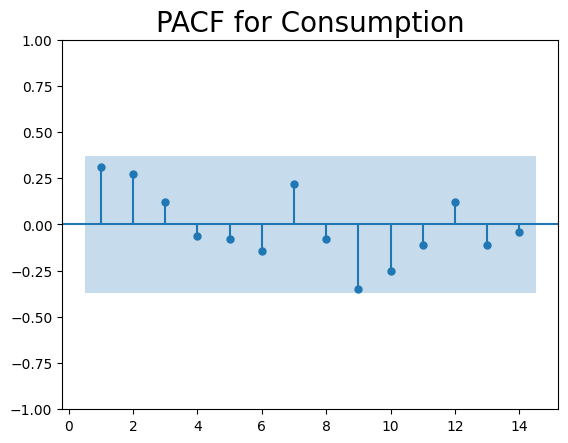

In [28]:
# Grafico de PACF
sgt.plot_pacf(df['Consumption'], zero = False, lags = 14)
plt.title("PACF for Consumption", size = 20)
plt.show()

El gráfico muestra la Función de Autocorrelación Parcial (PACF) para una serie temporal de consumo.

La PACF mide la correlación entre observaciones separadas por diferentes lapsos de tiempo (lags), después de eliminar los efectos de las observaciones intermedias. 

En este gráfico específico:

- El eje X representa los retrasos (lags) de 1 a 15 unidades de tiempo.
- El eje Y muestra los valores de correlación parcial, que varían aproximadamente entre -0.35 y 0.30.
- Cada punto azul representa el valor de autocorrelación parcial para un retraso específico.
- El área sombreada en azul claro posiblemente indica los límites de significancia estadística.

Se observan algunas correlaciones parciales que parecen significativas:
- En los lags 1 y 2 hay correlaciones positivas (aproximadamente 0.30 y 0.28)
- En el lag 3 hay una correlación positiva menor
- En los lags 10 y 9 hay correlaciones negativas notables
- La mayoría de los demás lags muestran correlaciones parciales débiles

Este tipo de gráfico es útil para identificar el orden apropiado para un modelo autorregresivo (AR) en análisis de series temporales. Los picos significativos sugieren qué retrasos podrían ser importantes para modelar la serie de consumo.

### Modelo AR(1)

In [29]:
# Probamos un modelo AR(1)
consumo_modelo_ar_1 = ARIMA(df, order=(1, 0, 0))
consumo_modelo_ar_1_resultados = consumo_modelo_ar_1.fit()
print(consumo_modelo_ar_1_resultados.summary())


                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                   28
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -153.959
Date:                Sat, 19 Apr 2025   AIC                            313.918
Time:                        23:48:20   BIC                            317.914
Sample:                    02-01-2022   HQIC                           315.139
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.6950     19.157      6.457      0.000      86.148     161.242
ar.L1          0.3212      0.246      1.303      0.192      -0.162       0.804
sigma2      3481.7515   2093.980      1.663      0.0

### Modelo AR(2)

In [30]:
# Probamos un modelo AR(2)
consumo_modelo_ar_2 = ARIMA(df, order=(2, 0, 0))
consumo_modelo_ar_2_resultados = consumo_modelo_ar_2.fit()
print(consumo_modelo_ar_2_resultados.summary())

                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                   28
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -152.572
Date:                Sat, 19 Apr 2025   AIC                            313.144
Time:                        23:48:20   BIC                            318.473
Sample:                    02-01-2022   HQIC                           314.773
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        118.1110     33.624      3.513      0.000      52.210     184.012
ar.L1          0.2370      0.209      1.135      0.256      -0.172       0.646
ar.L2          0.3153      0.228      1.385      0.1

In [31]:
# 1. Modelo de media constante ARIMA(0,0,0)
modelo_constante = SARIMAX(df, order=(0,0,0), trend='c')
resultado_constante = modelo_constante.fit(disp=False)
print(resultado_constante.summary())

                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                   28
Model:                        SARIMAX   Log Likelihood                -155.440
Date:                Sat, 19 Apr 2025   AIC                            314.881
Time:                        23:48:20   BIC                            317.545
Sample:                    02-01-2022   HQIC                           315.695
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    125.5648     13.169      9.535      0.000      99.754     151.375
sigma2      3885.4872   2539.250      1.530      0.126   -1091.351    8862.326
Ljung-Box (L1) (Q):                   3.03   Jarque-

In [32]:
# 2. Modelo ARMA(1,1)
modelo_arma11 = SARIMAX(df, order=(1,0,1), trend='c')
resultados_arma11 = modelo_arma11.fit(disp=False)
print(resultados_arma11.summary())

                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                   28
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -152.652
Date:                Sat, 19 Apr 2025   AIC                            313.304
Time:                        23:48:20   BIC                            318.633
Sample:                    02-01-2022   HQIC                           314.933
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     18.5167     35.999      0.514      0.607     -52.041      89.074
ar.L1          0.8365      0.279      2.999      0.003       0.290       1.383
ma.L1         -0.5476      0.354     -1.549      0.1

In [33]:
# 3. Modelo ARMA(2,1)
modelo_arma21 = SARIMAX(df, order=(2,0,1), trend='c')
resultado_arma21 = modelo_arma21.fit(disp=False)
print(resultado_arma21.summary())

                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                   28
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -152.197
Date:                Sat, 19 Apr 2025   AIC                            314.393
Time:                        23:48:20   BIC                            321.054
Sample:                    02-01-2022   HQIC                           316.429
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     24.3939     48.514      0.503      0.615     -70.693     119.481
ar.L1          0.5436      0.394      1.378      0.168      -0.230       1.317
ar.L2          0.2380      0.249      0.956      0.3

Analizando los resultados de todos los modelos que has ejecutado, puedo ofrecerte las siguientes conclusiones:

1. **Comparación por criterios de información**:
   - El modelo ARMA(1,1) tiene el mejor AIC (313.304)
   - El modelo AR(2) tiene el segundo mejor AIC (313.144)
   - El modelo con media constante ARIMA(0,0,0) tiene el peor AIC (314.881)

2. **Significancia de coeficientes**:
   - En el modelo ARMA(1,1), el coeficiente AR(1) es estadísticamente significativo (p=0.003), mientras que el MA(1) no lo es (p=0.121)
   - En los modelos AR(1) y AR(2), ningún coeficiente autorregresivo es estadísticamente significativo
   - En el modelo ARMA(2,1), ningún coeficiente es estadísticamente significativo

3. **Diagnósticos de residuos**:
   - Todos los modelos pasan las pruebas de diagnóstico (Ljung-Box, Jarque-Bera, Heterocedasticidad)
   - El modelo ARMA(2,1) tiene el mejor p-valor en la prueba Ljung-Box (0.92), sugiriendo la mejor eliminación de autocorrelación

**Recomendación**:

El modelo ARMA(1,1) parece ser la mejor opción porque:
1. Tiene el mejor AIC entre todos los modelos evaluados
2. Contiene un coeficiente estadísticamente significativo (ar.L1)
3. Tiene buenos diagnósticos de residuos
4. Es más parsimonioso que el ARMA(2,1)

El coeficiente AR(1) de 0.8365 en el modelo ARMA(1,1) indica una fuerte persistencia en la serie de consumo, lo que sugiere que los valores actuales están significativamente influenciados por los valores inmediatamente anteriores. Aunque el componente MA(1) no es estadísticamente significativo al nivel de 0.05, está relativamente cerca (p=0.121) y contribuye a mejorar el ajuste general del modelo.

Para finalizar la selección, recomendaría verificar la capacidad predictiva de los modelos ARMA(1,1) y AR(2) en una muestra de validación, si es posible, para confirmar que el modelo con mejor AIC también ofrece mejores pronósticos en la práctica.

In [34]:
train = df[:'2022-02-20']
test = df['2022-02-21':]

In [35]:
# Uso el mejor modelo ARMA(1,1) para predecir el consumo futuro
mejor_modelo = SARIMAX(train, order=(1,0,1), trend='c')
resultados_mejor_modelo = mejor_modelo.fit()
print(resultados_mejor_modelo.summary())

                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                   20
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -110.352
Date:                Sat, 19 Apr 2025   AIC                            228.705
Time:                        23:48:20   BIC                            232.688
Sample:                    02-01-2022   HQIC                           229.482
                         - 02-20-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     21.5459     50.087      0.430      0.667     -76.622     119.714
ar.L1          0.8311      0.396      2.099      0.036       0.055       1.607
ma.L1         -0.6066      0.532     -1.141      0.2

In [36]:
# Hago la prediccion para el periodo de prueba y 
# calculo el intervalo de confianza para el periodo de prueba
forecast = resultados_mejor_modelo.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [37]:
# Convierto a DataFrame para facilitar la comparación
forecast_df = pd.DataFrame({
    'Predicción': forecast_mean
}, index=test.index)

In [38]:
# Uno las predicciones con los valores reales
comparison = pd.concat([test, forecast_df], axis=1)
comparison.columns = ['Real', 'Predicción']

In [39]:
mse = mean_squared_error(comparison['Real'], comparison['Predicción'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(comparison['Real'], comparison['Predicción'])
mape = np.mean(np.abs((comparison['Real'] - comparison['Predicción']) / comparison['Real'])) * 100


In [40]:
print(f"\nMétricas de evaluación:")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%")


Métricas de evaluación:
Error Cuadrático Medio (MSE): 3229.46
Raíz del Error Cuadrático Medio (RMSE): 56.83
Error Absoluto Medio (MAE): 49.15
Error Porcentual Absoluto Medio (MAPE): 71.34%


In [41]:
print("\nValores Reales vs. Predicciones:")
print(comparison)


Valores Reales vs. Predicciones:
               Real  Predicción
DateTime                       
2022-02-21  149.144  137.636160
2022-02-22  207.428  135.929725
2022-02-23  124.748  134.511577
2022-02-24  101.980  133.333011
2022-02-25   93.772  132.353554
2022-02-26   47.980  131.539567
2022-02-27   46.224  130.863095
2022-02-28   68.024  130.300907


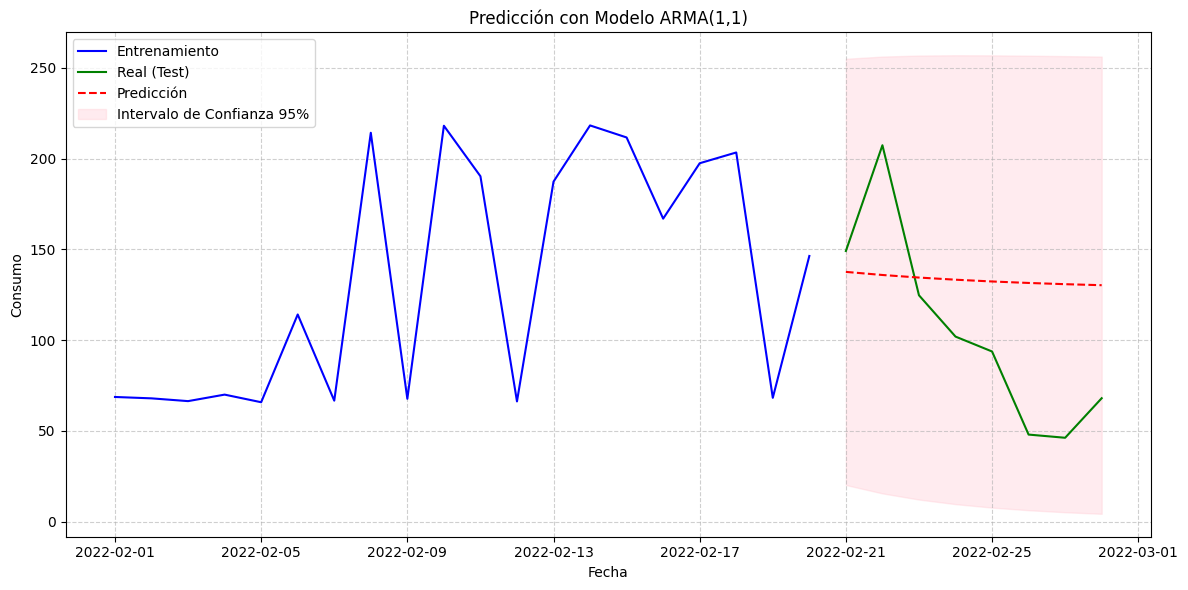

In [42]:
# Graficar
plt.figure(figsize=(12, 6))

# Graficar datos de entrenamiento
plt.plot(train.index, train['Consumption'], label='Entrenamiento', color='blue')

# Graficar datos de prueba
plt.plot(test.index, test['Consumption'], label='Real (Test)', color='green')

# Graficar predicciones
plt.plot(test.index, forecast_mean, label='Predicción', color='red', linestyle='--')

# Graficar intervalo de confianza
plt.fill_between(
    test.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='pink', alpha=0.3, label='Intervalo de Confianza 95%'
)

plt.title('Predicción con Modelo ARMA(1,1)')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Ajustar espacio para que se vea mejor
plt.tight_layout()
plt.show()


In [43]:
# modelo_arima3 = ARIMA(df, order=(3,0,0), seasonal_order=(1, 0, 0, 7))
# resultados_arima3 = modelo_arima3.fit()
# print(resultados_arima3.summary())